In [ ]:
# Load image 
# Split image into range and domain blocks
# Apply transformations to each block
# Compare range to domain blocks using metric
# Store transformations for each domain block
# Use Partitioned IFS to recreate image

In [116]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import DomainBlock as db
import cv2

In [117]:
class Partition:

    def __init__(self, image, block_size):
        
        self.rows, self.cols = image.shape

        if self.rows != self.cols:
            raise NotImplementedError("Only encodes square images")

        if self.rows % block_size != 0 or self.cols % block_size != 0:
            raise NotImplementedError("Image dimensions must be divisible by block size")
        
        self.block_size = block_size
        self.blocks_per_row = self.rows // self.block_size
        self.blocks_per_col = self.cols // self.block_size

        self.num_blocks = self.blocks_per_row * self.blocks_per_col
    
    def generate_blocks(self):
        domain_blocks = []

        for b in range(self.num_blocks):
            i_top_left = (b // self.blocks_per_row) * self.block_size
            j_top_left = (b % self.blocks_per_col) * self.block_size
            
            i_bot_right = i_top_left + self.block_size
            j_bot_right = j_top_left + self.block_size

            domain_blocks.append(db.DomainBlock((i_top_left, j_top_left), (i_bot_right, j_bot_right)))

        return domain_blocks


In [196]:
class ImageCompression():

    def __init__(self, image, domainBlocks, rangeBlocks):
        self.image = image
        self.domainBlocks = domainBlocks
        self.rangeBlocks = rangeBlocks
        possTransforms = self.generate_all_transforms()
        self.domainBlockTransforms = self.transform_all_blocks(possTransforms)

        self.encoded = self.encode()

    def generate_all_transforms(self):
    
        transforms = []

        for rotation in [0, 90, 180, 270]:
            for flip in [True, False]:
                transforms.append((flip, rotation))

        return transforms
    
    def transform_all_blocks(self, possTransforms):

        transforms = []

        for b in self.domainBlocks:

            transforms.extend(self.block_transforms(b, possTransforms))

        return transforms


    def block_transforms(self, domainBlock, possTransforms):

        transform_list = []

        top_left = domainBlock.top_left
        bot_right = domainBlock.bot_right

        domain_img = self.image[top_left[0]:bot_right[0], top_left[1]:bot_right[1]].copy()

        for flip, rotation in possTransforms:
            
            transformed = self.apply_transform(domain_img, flip, rotation)
            
            transform_list.append((domainBlock, flip, rotation, transformed))
        
        return transform_list
    
    def apply_transform(self, img, flip, rotation, s=1, o=0):

        transformed = img.copy()

        if flip:
            transformed = np.fliplr(transformed)
        
        currentRotation = 0

        while currentRotation < rotation:
            transformed = np.rot90(transformed)
            currentRotation += 90
        
        return (s * transformed) + o
    
    def compute_diff(self, range, domain, s, o):
        # currently using frobenius norm
        return np.sum(np.square(range - ((s * domain) + o)))
    
    def compute_s_o(self, range, domain):

        rows, cols = domain.shape

        n = rows * cols

        s = self.best_s(range, domain, n)
        o = self.best_o(range, domain, n, s)

        return s, o

        
    def best_s(self, range, domain, n):

        # Optimal alpha shown in Yuval Fisher book

        top_frac = (n * np.sum(range * domain)) - (np.sum(range) * np.sum(domain))

        bot_frac = (n * np.sum(np.square(domain))) - (np.sum(domain))^2

        return top_frac / bot_frac

    def best_o(self, range, domain, n, s):

        return (1/ n) * (np.sum(range) - s * np.sum(domain))
        
    def find_best_transform(self, rangeBlock):

        current_min = np.inf

        range_image = self.image[rangeBlock.top_left[0]:rangeBlock.bot_right[0], rangeBlock.top_left[1]:rangeBlock.bot_right[1]]

        for domainBlock, flip, rotation, transformation in self.domainBlockTransforms:


            s, o = self.compute_s_o(range_image, transformation)

            difference = self.compute_diff(range_image, transformation, s, o)

            if difference < current_min:

                current_min = difference
                best_contraction = (domainBlock, flip, rotation, s, o)

        return best_contraction

    def encode(self):

        encoded = []

        for i, rangeBlock in enumerate(self.rangeBlocks):

            print(f"Encoding block {i + 1} of {len(self.rangeBlocks)}")
            
            code_block = self.find_best_transform(rangeBlock)

            encoded.append(code_block)
        
        return encoded
    
    def decode(self, iterations):

        n = int(np.sqrt(len(self.encoded)))

        blockSize = abs(self.domainBlocks[0].bot_right[0] - self.domainBlocks[0].top_left[0])

        current_image = np.random.randint(0, 256, (n * blockSize, n * blockSize))
        partition_cur = Partition(current_image, blockSize).generate_blocks()

        for i in range(iterations):

            for rangeIndex, (domainBlock, flip, rotation, s, o) in enumerate(self.encoded):
                
                # Need to resize to range block size before applying
                domainBlock_image = current_image[domainBlock.top_left[0]:domainBlock.bot_right[0], domainBlock.top_left[1]:domainBlock.bot_right[1]] 

                rangeBlock = partition_cur[rangeIndex]

                current_image[rangeBlock.top_left[0]:rangeBlock.bot_right[0], rangeBlock.top_left[1]:rangeBlock.bot_right[1]] = self.apply_transform(domainBlock_image, flip, rotation, s, o)


        return current_image

In [197]:
image = cv2.imread("lena.jpg", 0)

range_image = cv2.resize(image, (image.shape[1] // 4, image.shape[0] // 4))
domain_image = cv2.resize(image, (image.shape[1] // 8, image.shape[0] // 8))

range_partition = Partition(range_image, 8).generate_blocks()
domain_partition = Partition(domain_image, 8).generate_blocks()
                         
compression = ImageCompression(range_image, domain_partition, range_partition)

Encoding block 1 of 256
Encoding block 2 of 256
Encoding block 3 of 256
Encoding block 4 of 256
Encoding block 5 of 256
Encoding block 6 of 256
Encoding block 7 of 256
Encoding block 8 of 256
Encoding block 9 of 256
Encoding block 10 of 256
Encoding block 11 of 256
Encoding block 12 of 256
Encoding block 13 of 256
Encoding block 14 of 256
Encoding block 15 of 256
Encoding block 16 of 256
Encoding block 17 of 256
Encoding block 18 of 256
Encoding block 19 of 256
Encoding block 20 of 256
Encoding block 21 of 256
Encoding block 22 of 256
Encoding block 23 of 256
Encoding block 24 of 256
Encoding block 25 of 256
Encoding block 26 of 256
Encoding block 27 of 256
Encoding block 28 of 256
Encoding block 29 of 256
Encoding block 30 of 256
Encoding block 31 of 256
Encoding block 32 of 256
Encoding block 33 of 256
Encoding block 34 of 256
Encoding block 35 of 256
Encoding block 36 of 256
Encoding block 37 of 256
Encoding block 38 of 256
Encoding block 39 of 256
Encoding block 40 of 256
Encoding 

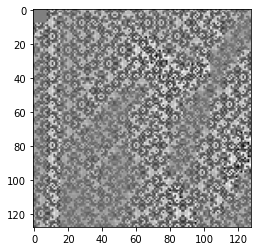

In [203]:
decoded = compression.decode(2)

plt.imshow(decoded, cmap="gray")

